In [1]:
"""
Ravi Patel
Objective: Get dwelling and totoal premium from pdfs
Notes: Here, the decision was made to bypass attempting the search for the page with the keyword because of limited time. 
Plan: 
    1. Split pdfs into images
    2. Use either pytesseract or easyocr to extract text
    3. Use jellyfish to compare text to keywords
    4. If keywords are found, then attempt to gather only numbers from rows. 
Improvements:
    - Attempt to index all of the text for search later to find page to focus on.
    - Ingest data from pdfs into a vector database and use AI query to find data.
    - Check viability of zeroshot model to query image
    - Evaluate CV models to find specific matches
    
"""

import fitz
import matplotlib.pyplot as plt
import jellyfish
import cv2
import numpy as np
import pytesseract
import os
import easyocr
from PIL import Image

reader = easyocr.Reader(['en'])

/Users/ravipatel/projects/holistaplan/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def split_pdf(pdf_path: str, output_path: str):
    """
    Splits a PDF file into individual pages and saves each page as a PNG image.

    Parameters:
    pdf_path (str): The path to the PDF file to be split.
    output_path (str): The directory where the output PNG images will be saved.

    Returns:
    None
    """
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    doc = fitz.open(pdf_path)
    for page_number, page_data in enumerate(doc):
        pix = page_data.get_pixmap()
        img_path = os.path.join(output_path, f"page-{page_number}.png")
        pix.save(img_path)
    doc.close()

In [3]:
CURRENT_OUTPUT_DIR = 'auto-8'
split_pdf('auto-8.pdf',CURRENT_OUTPUT_DIR)


In [4]:
def get_phrase_value(
    phrase: str, image_path: str, show_image: bool = False, threshold: float = 0.8
):
    """
    Extracts and returns the values of a given phrase from an image.

    Parameters:
    phrase (str): The phrase to search for in the image.
    image_path (str): The path to the image file.
    show_image (bool, optional): If True, the image with the found phrase highlighted will be displayed. Defaults to False.
    threshold (float, optional): The similarity threshold for the phrase match. Defaults to 0.8.

    Returns:
    list: A list of values associated with the found phrase in the image.
    """
    result = reader.readtext(image_path)
    res = [
        result_
        for result_ in result
        if jellyfish.jaro_similarity(result_[1].lower(), phrase) > threshold
    ]
    #TODO: Refactor code to remove repeat loops
    if show_image:
        show_image = cv2.imread(image_path)
        for phrase_found in res:
            x_min, y_min = [int(min(cord)) for cord in zip(*phrase_found[0])]
            x_max, y_max = [int(max(cord)) for cord in zip(*phrase_found[0])]
            font = cv2.FONT_HERSHEY_SIMPLEX
            show_image = cv2.rectangle(
                show_image,
                (x_min, y_min),
                (x_max, y_max),
                (0, 255, 0),
                3,
            )
            show_image = cv2.putText(
                show_image,
                f"<{phrase}>",
                (x_min, y_min),
                font,
                1,
                (255, 0, 0),
                3,
                cv2.LINE_AA,
            )
        _, ax = plt.subplots(figsize=(15, 15))
        ax.imshow(show_image)
        ax.axis("off")
        plt.show()

    rates = []
    for phrase_found in res:
        x_min, y_min = [int(min(cord)) for cord in zip(*phrase_found[0])]
        x_max, y_max = [int(max(cord)) for cord in zip(*phrase_found[0])]
        current = cv2.imread(image_path)
        # Add buffer to ensure all text is captured
        row = Image.fromarray(current[y_min - 1 : y_max + 1, :])
        rate = pytesseract.image_to_string(
            row, config="-c tessedit_char_whitelist=0123456789."
        ).strip()
        if rate:
            rates.append(rate)
    return rates

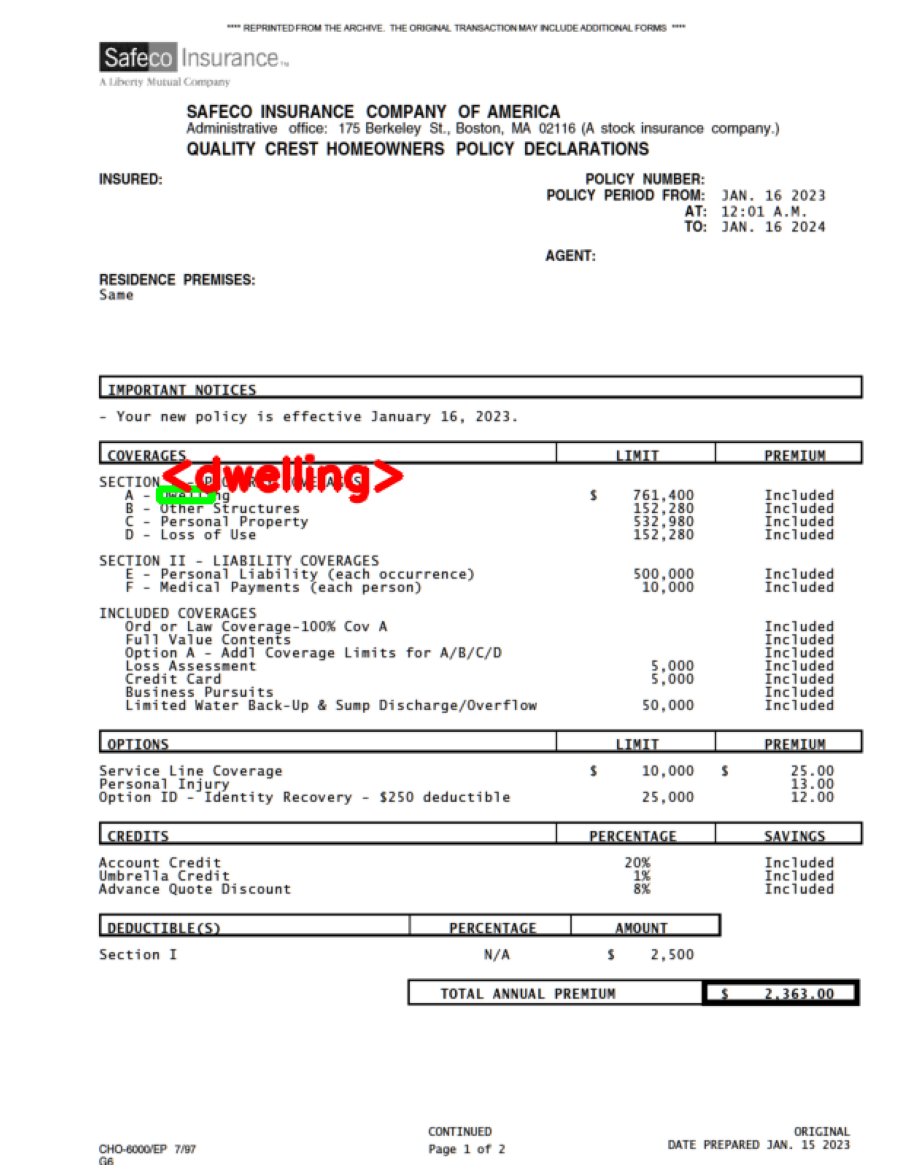

['761.400']


['761.400']

In [5]:
get_phrase_value('dwelling', f'{CURRENT_OUTPUT_DIR}/page-10.png', show_image=True)
# We found it.

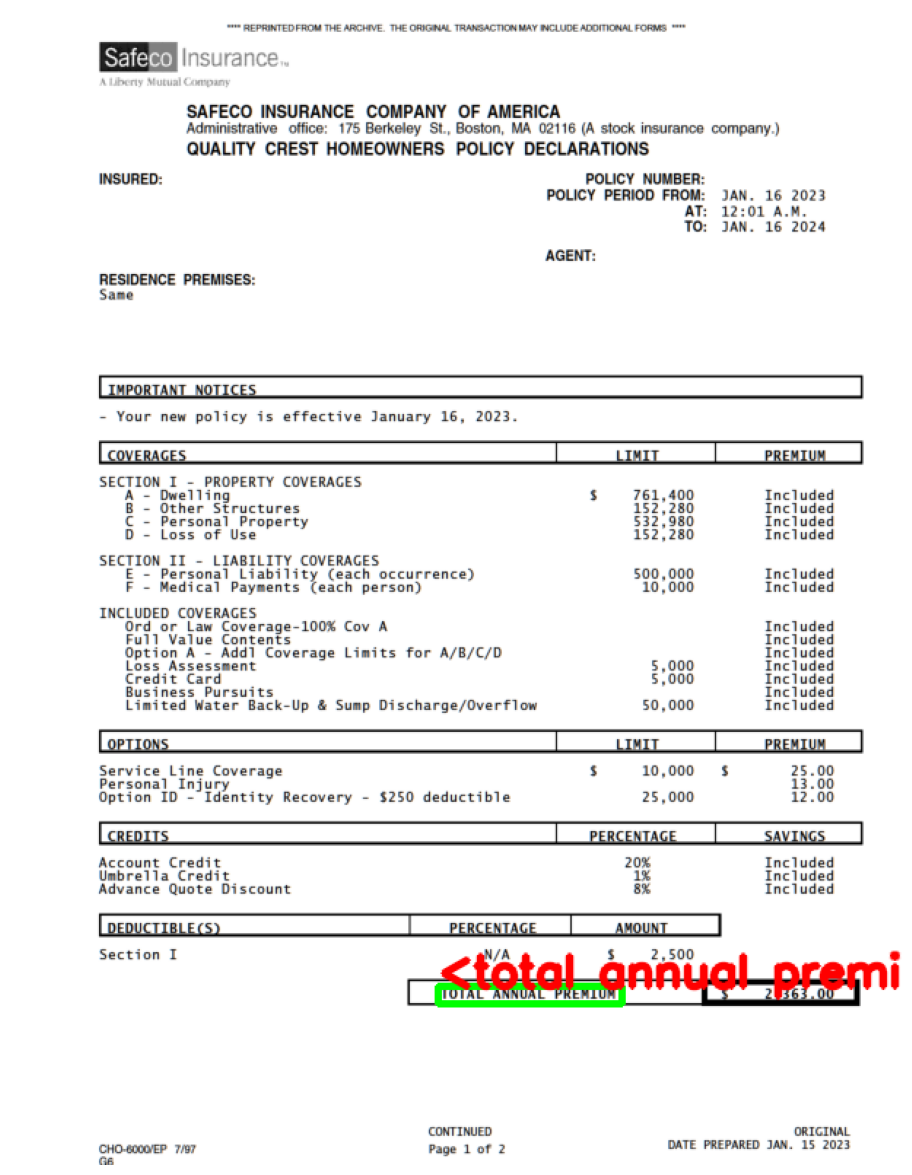

['2363.00']


['2363.00']

In [6]:
get_phrase_value('total annual premium', f'{CURRENT_OUTPUT_DIR}/page-10.png', show_image=True)
# Found it.

In [7]:
CURRENT_OUTPUT_DIR = "auto19"
split_pdf("auto19.pdf", CURRENT_OUTPUT_DIR)

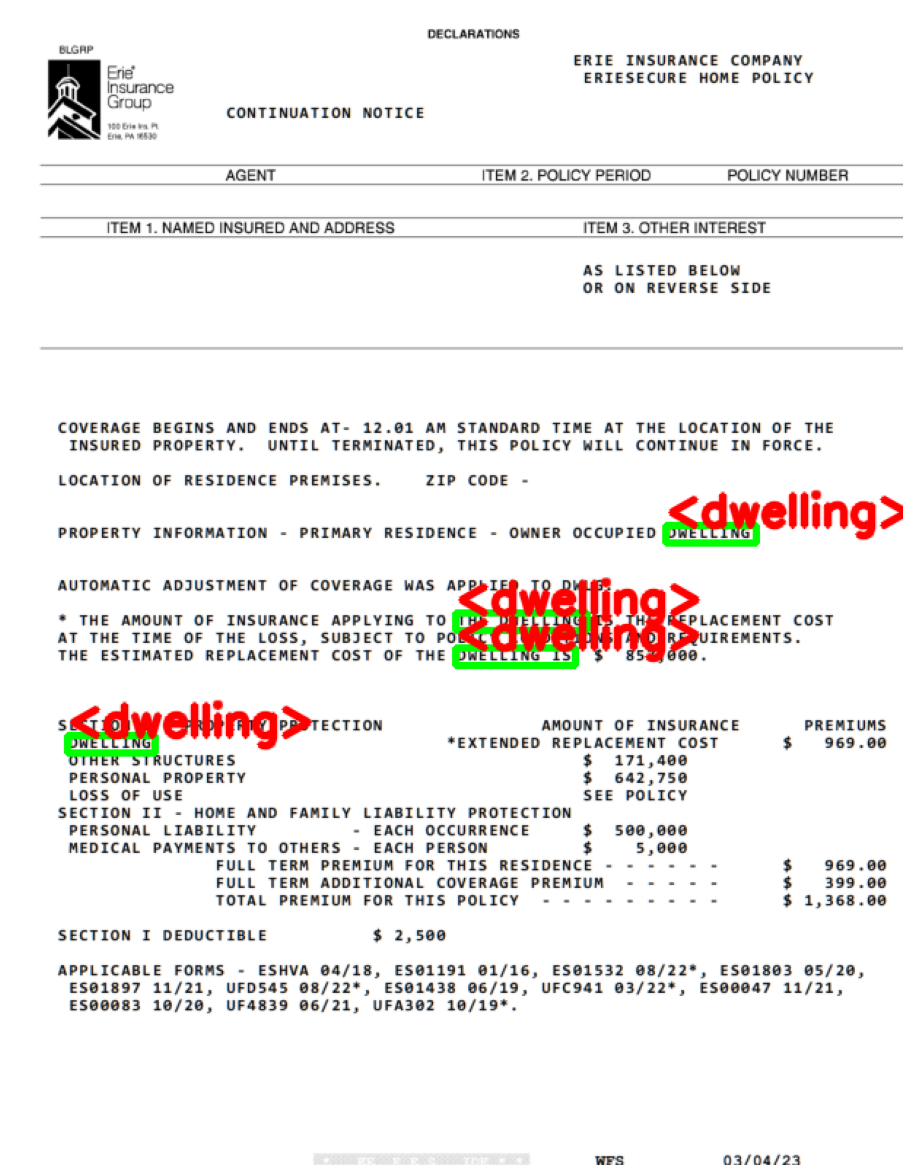

['050', '0857000.', '0 969.00']


['050', '0857000.', '0 969.00']

In [8]:
get_phrase_value('dwelling', f'{CURRENT_OUTPUT_DIR}/page-2.png', show_image=True)
# this one will require some more TLC to get the correct value, possible opportunity evaluate against the distribution of other values. 

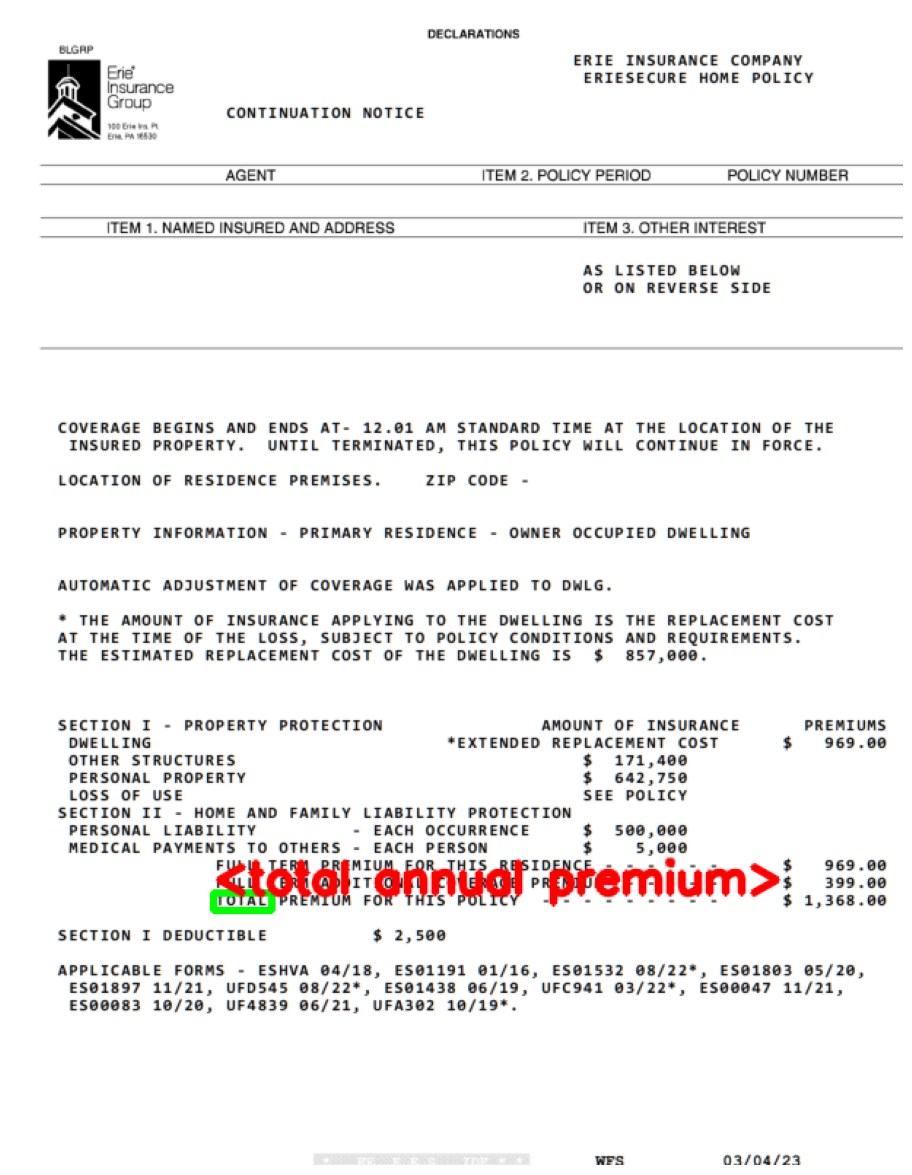

['1.368.00']


['1.368.00']

In [9]:
get_phrase_value('total annual premium', f'{CURRENT_OUTPUT_DIR}/page-2.png', show_image=True, threshold=0.7)
# Found it.